In [1]:
# imports
from collections import Counter
import datetime
import os
import pickle
import subprocess
import seaborn as sns; sns.set()
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertForSequenceClassification
from transformers import Trainer
from transformers.training_args import TrainingArguments

from geneformer import DataCollatorForCellClassification

## 1. Finetune model

In [2]:
train_dataset = load_from_disk("tokenize-data/query_hPBMCs2.dataset/")
train_dataset

Dataset({
    features: ['input_ids', 'donor', 'cell_type', 'cell_subtype', 'length'],
    num_rows: 20886
})

In [3]:
# shuffle datasets and rename columns
train_dataset = train_dataset.shuffle(seed=42)
train_dataset = train_dataset.rename_column(original_column_name='cell_subtype', new_column_name='label')
train_dataset

Dataset({
    features: ['input_ids', 'donor', 'cell_type', 'label', 'length'],
    num_rows: 20886
})

In [4]:
# create dictionary of cell types : label ids
target_names = train_dataset.unique('label')
target_name_id_dict = {target_names[i]:i for i in range(len(target_names))}

In [5]:
target_name_id_dict

{'bnaive': 0,
 'mono14': 1,
 'cd4mem': 2,
 'cd4naive': 3,
 'cd8eff': 4,
 'cd8naive': 5,
 'cd8mem': 6,
 'bmem': 7,
 'adc': 8,
 'mono16': 9,
 'nk': 10,
 'treg': 11,
 'unassigned': 12,
 'hsc': 13,
 'mk': 14,
 'pdc': 15}

In [6]:
Counter(train_dataset['label'])

Counter({'mono14': 4929,
         'cd4naive': 3528,
         'cd4mem': 2286,
         'cd8eff': 2026,
         'bnaive': 1907,
         'cd8naive': 1452,
         'bmem': 1076,
         'nk': 923,
         'mono16': 887,
         'cd8mem': 456,
         'adc': 410,
         'unassigned': 371,
         'treg': 298,
         'pdc': 153,
         'mk': 120,
         'hsc': 64})

In [7]:
# change labels to numerical ids
train_dataset = train_dataset.map(lambda x: {'label': target_name_id_dict[x['label']]}, num_proc=8)

/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [8]:
Counter(train_dataset['label'])

Counter({1: 4929,
         3: 3528,
         2: 2286,
         4: 2026,
         0: 1907,
         5: 1452,
         7: 1076,
         10: 923,
         9: 887,
         6: 456,
         8: 410,
         12: 371,
         11: 298,
         15: 153,
         14: 120,
         13: 64})

In [9]:
# create 80/20 train/eval splits
train_size = round(len(train_dataset) * 0.8)
labeled_train_split = train_dataset.select(range(train_size))
labeled_test_split = train_dataset.select(range(train_size, len(train_dataset)))

In [10]:
labeled_train_split

Dataset({
    features: ['input_ids', 'donor', 'cell_type', 'label', 'length'],
    num_rows: 16709
})

In [11]:
labeled_test_split

Dataset({
    features: ['input_ids', 'donor', 'cell_type', 'label', 'length'],
    num_rows: 4177
})

In [12]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # calculate accuracy and macro f1 using sklearn's function
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    return {
      'accuracy': acc,
      'macro_f1': macro_f1
    }

In [26]:
# set model parameters
# max input size
max_input_size = 2 ** 11  # 2048

# set training hyperparameters
# max learning rate
max_lr = 5e-5
# how many pretrained layers to freeze
freeze_layers = 0
# number gpus
num_gpus = 1
# number cpu cores
num_proc = 8
# batch size for training and eval
geneformer_batch_size = 12 ## 改这里以适应显卡的显存大小
# learning schedule
lr_schedule_fn = "linear"
# warmup steps
warmup_steps = 500
# number of epochs
epochs = 2
# optimizer
optimizer = "adamw"

In [27]:
# set logging steps
logging_steps = round(len(labeled_train_split)/geneformer_batch_size/10)

In [28]:
logging_steps

139

In [29]:
# reload pretrained model
model = BertForSequenceClassification.from_pretrained("./Geneformer/", 
                                                      num_labels=len(target_name_id_dict.keys()),
                                                      output_attentions = False,
                                                      output_hidden_states = False).to('cuda')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./Geneformer/ and are newly initialized: ['classifier.weight', 'bert.pooler.dense.bias', 'classifier.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
## 模型参数
sum(i.numel() for i in model.parameters()) / 1e4

1026.6896

In [18]:
# define output directory path
project = 'PBMC'
current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
output_dir = f"./finetuned-models/{datestamp}_geneformer_CellClassifier_{project}_L{max_input_size}_B{geneformer_batch_size}_LR{max_lr}_LS{lr_schedule_fn}_WU{warmup_steps}_E{epochs}_O{optimizer}_F{freeze_layers}/"

In [31]:
output_dir

'./finetuned-models/231203_geneformer_CellClassifier_PBMC_L2048_B1_LR5e-05_LSlinear_WU500_E2_Oadamw_F0/'

In [32]:
# ensure not overwriting previously saved model
saved_model_test = os.path.join(output_dir, f"pytorch_model.bin")
if os.path.isfile(saved_model_test) == True:
    raise Exception("Model already saved to this directory.")

In [33]:
# make output directory
subprocess.call(f'mkdir -p {output_dir}', shell=True)

0

In [34]:
# set training arguments
training_args = {
    "learning_rate": max_lr,
    "do_train": True,
    "do_eval": True,
    "evaluation_strategy": "epoch",
    "save_strategy": "epoch",
    "logging_steps": logging_steps,
    "group_by_length": True,
    "length_column_name": "length",
    "disable_tqdm": False,
    "lr_scheduler_type": lr_schedule_fn,
    "warmup_steps": warmup_steps,
    "weight_decay": 0.001,
    "per_device_train_batch_size": geneformer_batch_size,
    "per_device_eval_batch_size": geneformer_batch_size,
    "num_train_epochs": epochs,
    "load_best_model_at_end": True,
    "output_dir": output_dir,
}

In [35]:
training_args_init = TrainingArguments(**training_args)

In [36]:
# create the trainer
trainer = Trainer(
    model=model,
    args=training_args_init,
    data_collator=DataCollatorForCellClassification(),
    train_dataset=labeled_train_split,
    eval_dataset=labeled_test_split,
    compute_metrics=compute_metrics
)

In [37]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.524300,0.498582,0.867369,0.645099
2,0.328700,0.356903,0.891310,0.701384


/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


TrainOutput(global_step=2786, training_loss=0.8199688277480761, metrics={'train_runtime': 288.2372, 'train_samples_per_second': 115.939, 'train_steps_per_second': 9.666, 'total_flos': 833922539507520.0, 'train_loss': 0.8199688277480761, 'epoch': 2.0})

In [38]:
predictions = trainer.predict(labeled_test_split)

/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


In [40]:
with open(f"{output_dir}predictions.pickle", "wb") as fp:
    pickle.dump(predictions, fp)

In [41]:
trainer.save_metrics("eval",predictions.metrics)
trainer.save_model(output_dir)

## 2. Inference via finetuned model

In [45]:
import numpy as np
import torch
from datasets import load_from_disk
from transformers import BertForSequenceClassification

In [44]:
def trunc_and_pad_input_id(x, max_len=2048, pad_token_id=0):
    input_id = torch.tensor(x['input_ids'])
    length = x['length']
    input_id = input_id[0:max_len] if length > max_len else input_id # 截断
    input_ids_pad = torch.nn.functional.pad(input_id, 
                                            pad=(0, max_len - input_id.numel()), 
                                            mode='constant', 
                                            value=pad_token_id)
    return {'input_ids_pad': input_ids_pad}

def collate_fn(data):
    input_ids = [np.array(i['input_ids_pad']) for i in data]
    # 转换为tensor
    input_ids = torch.tensor(np.array(input_ids), dtype=torch.int32)
    attention_mask = (input_ids > 0).to(torch.int32)
    return input_ids, attention_mask

def calculate_cell_embeddings(hidden_state, attention_mask):
    batch_size = attention_mask.shape[0]
    length = (attention_mask > 0).to(torch.float).sum(axis=1).reshape(batch_size, 1)
    length = length.reshape(batch_size, 1)
    attention_mask = attention_mask.reshape(batch_size, 2048, 1)
    cell_embeddings = hidden_state * attention_mask
    cell_embeddings = cell_embeddings.sum(axis=1)
    cell_embeddings /= length
    return cell_embeddings

In [46]:
## Load model
model = BertForSequenceClassification.from_pretrained(
    "./finetuned-models/231203_geneformer_CellClassifier_PBMC_L2048_B1_LR5e-05_LSlinear_WU500_E2_Oadamw_F0/", 
    output_hidden_states=True, 
    output_attentions=False)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(25426, 256, padding_idx=0)
      (position_embeddings): Embedding(2048, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.02, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.02, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12

In [48]:
data = load_from_disk('tokenize-data/query_hPBMCs2.dataset/')
data = data.map(trunc_and_pad_input_id, num_proc=8)
data

/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Dataset({
    features: ['input_ids', 'donor', 'cell_type', 'cell_subtype', 'length', 'input_ids_pad'],
    num_rows: 20886
})

In [49]:
## 适当调低batch_size可以降低对显存的占用，
## batch_size=10 taken up 6G GPU memory 
## batch_size=1  taken up 1G GPU memory
loader = torch.utils.data.DataLoader(
    data,
    batch_size=10,
    drop_last=False, 
    shuffle=False, 
    num_workers=4, 
    collate_fn=collate_fn
)

In [50]:
%%time
from tqdm import tqdm
cell_embeddings = []
## 如果你有GPU，那么使用如下代码进行推理
device = torch.device('cuda', 0)
if model.device != device:
    model = model.to(device)
for i, (input_ids, attention_mask) in tqdm(enumerate(loader), total = len(loader)):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    hidden_state = outputs.hidden_states[-1] # the last layer
    cell_embedding = calculate_cell_embeddings(hidden_state, attention_mask)
    cell_embeddings.append(cell_embedding.to('cpu'))

100%|███████████████████████████████████████████████████| 2089/2089 [01:37<00:00, 21.42it/s]

CPU times: user 1min 35s, sys: 1.61 s, total: 1min 37s
Wall time: 1min 37s


In [51]:
cell_embeddings = torch.cat(cell_embeddings, dim=0)
cell_embeddings.shape

torch.Size([20886, 256])

In [52]:
import scanpy as sc
adata = sc.read_h5ad('./example-data/query_hPBMCs.h5ad')
adata.obsm['X_GF'] = np.array(cell_embeddings)
adata

AnnData object with n_obs × n_vars = 20886 × 31133
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor', 'nUMI', 'nGene', 'percent_mito', 'cell_type', 'res_0.80', 'cell_subtype', 'DF.classifications', 'n_counts'
    var: 'name'
    obsm: 'X_GF'

In [53]:
sc.pp.neighbors(adata, use_rep='X_GF', n_pcs=256)
sc.tl.umap(adata)

/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jarning/miniconda3/envs/Geneformer-env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

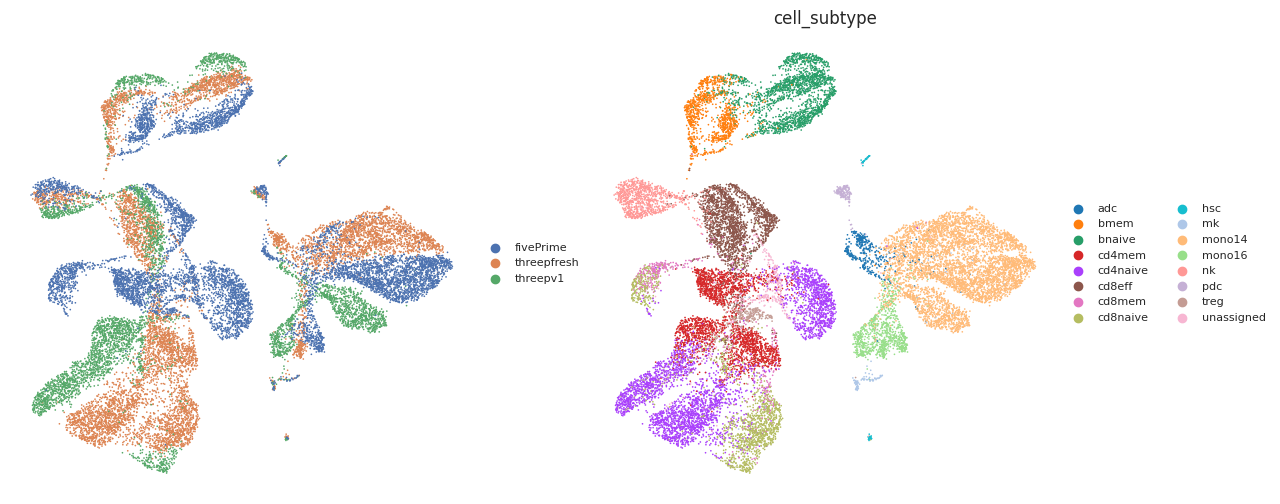

In [54]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (6,6)}):
    sc.pl.embedding(adata, basis='X_umap', color = ['donor', 'cell_subtype'], title='',
                    frameon=False, legend_fontsize=8, legend_fontoutline=1)